<img src = 'https://raw.githubusercontent.com/bgonzalezgo/Analisis_de_datos_COVID19/refs/heads/main/logo_uc_grande.png' alt = 'Encabezado' width = '100%'> </img>

**Especializacón en Big Data y Analítica de Datos** <br><br>
***Materia: Limpieza y tranformación de datos*** <br><br>
***Actividad Evaluativa: Taller de Integración y Análisis de Datos de Salud Pública*** <br><br>
***Estudiantes: Brandon González Gómez - María Alejandra Tejada Orjuela - Leydy Johana Silva Ruiz***

# *Actividad a resolver*

1. Escenario del Problema 🏥 <br>
Formas parte del equipo de analistas de datos del Ministerio de Salud. Tu misión es consolidar
los datos sobre la pandemia de COVID-19 que se reportan diariamente desde diferentes
ciudades. La información está fragmentada: los casos diarios, los datos de vacunación y las
características demográficas de cada ciudad se encuentran en archivos separados.
Para poder analizar el impacto de la pandemia y la efectividad de las campañas de
vacunación, es indispensable crear un dataset maestro unificado. Tu objetivo no es solo
realizar este análisis una vez, sino construir un proceso automatizado y robusto que permita
al ministerio integrar nuevos datos de manera rápida y fiable en el futuro.<br> <br>
2. Objetivos de Aprendizaje 🎯 <br>
Al completar este taller, serás capaz de: <br>
● Combinar reportes de datos de diferentes regiones en un único dataset (pd.concat). <br>
● Enriquecer datos de salud con información complementaria (vacunación, demografía)
usando pd.merge con claves simples y compuestas. <br>
● Aplicar diferentes tipos de JOIN y justificar su uso en un contexto de salud pública. <br>
● Crear variables calculadas (KPIs) relevantes para el análisis epidemiológico. <br>
● Reestructurar y ordenar datos para analizar la evolución de la pandemia por ciudad y
fecha (sort_values, pivot_table). <br>
● Automatizar un pipeline de procesamiento de datos de salud encapsulando la lógica
en una función reutilizable. <br>
● Validar la consistencia e integridad de un dataset integrado. <br>
● Exportar los resultados para la creación de reportes y análisis posteriores.<br> <br>
3. Materiales Requeridos 📁 <br>
Asegúrate de tener en tu directorio de trabajo los siguientes 5 archivos CSV: <br>
● casos_bogota.csv <br>
● casos_medellin.csv <br>
● casos_cali.csv <br>
● vacunacion_nacional.csv <br>
● demografia_ciudades.csv <br>

## *Configuración del Entorno*

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import warnings
import io
import os
import glob
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
from plotly.subplots import make_subplots

# Configuraciones para visualización
warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
sns.set_palette('husl')

# Configuración para pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print('✅ Librerías importadas exitosamente')
print(f'Versión de pandas: {pd.__version__}')
print(f'Versión de numpy: {np.__version__}')
print(f'Versión de seaborn: {sns.__version__}')
print(f'Versión de matplotlib: {matplotlib.__version__}')

✅ Librerías importadas exitosamente
Versión de pandas: 2.1.4
Versión de numpy: 1.26.4
Versión de seaborn: 0.13.2
Versión de matplotlib: 3.7.5


## *📁 Carga y Exploración Inicial*

**Instrucciones de carga de archivos:**
1. Carga los siguientes archivos usando un repositorio de GitHub:
   - `casos_bogotá.csv`
   - `casos_cali.csv`
   - `casos_medellín.csv`
   - `demografia_ciudades.csv`
   - `vacunacion_nacional.csv`

In [19]:
# Función para verificar y cargar archivos.
# Nota: Primero busca en el directorio local y si no encuentra, lo descarga desde GitHub.
def verificar_y_descargar_archivos_github():
    '''
    Verifica si los archivos necesarios existen localmente y los descarga de un repositorio de GitHub si no están.
    '''
    repo_url = 'https://raw.githubusercontent.com/bgonzalezgo/Analisis_de_datos_COVID19/main/'

    archivos_requeridos = [
        'casos_bogotá.csv',
        'casos_cali.csv',
        'casos_medellín.csv',
        'demografia_ciudades.csv',
        'vacunacion_nacional.csv'
    ]

    archivos_faltantes = []
    print('🔍 Verificando archivos requeridos...')
    for archivo in archivos_requeridos:
        if not os.path.exists(archivo):
            archivos_faltantes.append(archivo)
            print(f'❌ {archivo} - No encontrado localmente. Descargando directamente desde repositorio GitHub...')
            try:
                url_completa = repo_url + archivo
                respuesta = requests.get(url_completa)
                respuesta.raise_for_status()  # Lanza un error si la descarga falla
                with open(archivo, 'wb') as f:
                    f.write(respuesta.content)
                print(f'✅ {archivo} - Descargado y guardado correctamente.')
            except requests.exceptions.RequestException as e:
                print(f'⚠️  Error al descargar {archivo}: {e}')
                return False
        else:
            print(f'✅ {archivo} - Encontrado localmente.')

    if archivos_faltantes:
        print(f'\n🎉 Todos los archivos han sido verificados y descargados si fue necesario.')
    else:
        print(f'\n🎉 Todos los archivos ya estaban disponibles localmente.')

    return True

# Llama a la función para verificar y descargar
archivos_listos = verificar_y_descargar_archivos_github()

# Puedes usar esta variable para decidir si continuar con el análisis
if archivos_listos:
    print(f'\n¡Listo para comenzar el análisis de datos!')

🔍 Verificando archivos requeridos...
✅ casos_bogotá.csv - Encontrado localmente.
✅ casos_cali.csv - Encontrado localmente.
✅ casos_medellín.csv - Encontrado localmente.
✅ demografia_ciudades.csv - Encontrado localmente.
✅ vacunacion_nacional.csv - Encontrado localmente.

🎉 Todos los archivos ya estaban disponibles localmente.

¡Listo para comenzar el análisis de datos!


In [20]:
# Cargar archivos individuales si están disponibles
if archivos_listos:
    try:
        # Cargar archivos de casos por ciudad
        print('📊 Cargando archivos de casos por ciudad...')
        df_bogota = pd.read_csv('casos_bogotá.csv')
        df_cali = pd.read_csv('casos_cali.csv')
        df_medellin = pd.read_csv('casos_medellín.csv')

        print(f'   ✅ Bogotá: {df_bogota.shape[0]} registros, {df_bogota.shape[1]} columnas')
        print(f'   ✅ Cali: {df_cali.shape[0]} registros, {df_cali.shape[1]} columnas')
        print(f'   ✅ Medellín: {df_medellin.shape[0]} registros, {df_medellin.shape[1]} columnas')

        # Cargar datos maestros
        print('\n📋 Cargando datos maestros...')
        df_demografia_ciudad = pd.read_csv('demografia_ciudades.csv')
        df_vacunacion = pd.read_csv('vacunacion_nacional.csv')

        print(f'   ✅ Demografia ciudad: {df_demografia_ciudad.shape[0]} ciudades, {df_demografia_ciudad.shape[1]} columnas')
        print(f'   ✅ Vacunación: {df_vacunacion.shape[0]} dosis administradas, {df_vacunacion.shape[1]} columnas')
        print('\n🎯 Todos los datasets cargados exitosamente')

        # --- INSPECCIÓN INICIAL DE DATOS (Paso 1) ---
        print('\n🔍 Realizando inspección inicial de DataFrames:')

        # Inspección de casos de Bogotá
        print('\n--- Información de df_bogota ---')
        df_bogota.info()
        print('\n--- Vista previa de df_bogota ---')
        print(df_bogota.head())

        # Inspección de casos de Cali
        print('\n--- Información de df_cali ---')
        df_cali.info()
        print('\n--- Vista previa de df_cali ---')
        print(df_cali.head())

        # Inspección de casos de Medellín
        print('\n--- Información de df_medellin ---')
        df_medellin.info()
        print('\n--- Vista previa de df_medellin ---')
        print(df_medellin.head())

        # Inspección de demografía
        print('\n--- Información de df_demografia_ciudad ---')
        df_demografia_ciudad.info()
        print('\n--- Vista previa de df_demografia_ciudad ---')
        print(df_demografia_ciudad.head())

        # Inspección de vacunación
        print('\n--- Información de df_vacunacion ---')
        df_vacunacion.info()
        print('\n--- Vista previa de df_vacunacion ---')
        print(df_vacunacion.head())

    except Exception as e:
        print(f'❌ Error al cargar archivos: {e}')
        print('💡 Verifica que los archivos estén en el formato correcto')
else:
    print('⏸️  Esperando a que se suban todos los archivos requeridos...')

📊 Cargando archivos de casos por ciudad...
   ✅ Bogotá: 840 registros, 5 columnas
   ✅ Cali: 840 registros, 5 columnas
   ✅ Medellín: 840 registros, 5 columnas

📋 Cargando datos maestros...
   ✅ Demografia ciudad: 3 ciudades, 4 columnas
   ✅ Vacunación: 2520 dosis administradas, 4 columnas

🎯 Todos los datasets cargados exitosamente

🔍 Realizando inspección inicial de DataFrames:

--- Información de df_bogota ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Fecha              840 non-null    object
 1   Ciudad             840 non-null    object
 2   Casos_Confirmados  840 non-null    int64 
 3   Fallecidos         840 non-null    int64 
 4   Recuperados        840 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 32.9+ KB

--- Vista previa de df_bogota ---
        Fecha       Ciudad  Casos_Confirmados  Fallecidos  Recup

### 🔍 Exploración Inicial del Dataset

Realizamos una primera inspección para entender la estructura y contenido de nuestros datos, para luego planificar la estrategía de integración y combinar los datos de la forma correcta.

In [21]:
# Exploración de archivos de vacunación
if archivos_listos:
    print(f'{"-"*10} EXPLORACIÓN DE DATOS DE VACUNACION {"-"*10}')

    # Verificar estructura consistente entre las ciudades
    print("\n📊 Verificando consistencia de estructura:")

    datasets_vacunacion = {
        'Bogotá': df_bogota,
        'Cali': df_cali,
        'Medellín': df_medellin
    }

    for ciudad, df in datasets_vacunacion.items():
        print(f'\n🗓️  {ciudad} :')
        print(f'   📏 Dimensiones: {df.shape}')
        print(f'   📋 Columnas: {list(df.columns)}')
        print(f'   🔢 Tipos de datos: {df.dtypes.to_dict()}')

    # Mostrar muestra de datos de bogotá
    print('\n📋 Muestra de datos (Bogotá):')
    display(df_bogota.head())

    # Verificar rangos de fechas
    print('\n📅 Verificando rangos de fechas:')
    for ciudad, df in datasets_vacunacion.items():
        df_temp = df.copy()
        df_temp['Fecha'] = pd.to_datetime(df_temp['Fecha'])
        fecha_min = df_temp['Fecha'].min()
        fecha_max = df_temp['Fecha'].max()
        print(f'   {ciudad}: {fecha_min.strftime("%Y-%m-%d")} a {fecha_max.strftime("%Y-%m-%d")}')

---------- EXPLORACIÓN DE DATOS DE VACUNACION ----------

📊 Verificando consistencia de estructura:

🗓️  Bogotá :
   📏 Dimensiones: (840, 5)
   📋 Columnas: ['Fecha', 'Ciudad', 'Casos_Confirmados', 'Fallecidos', 'Recuperados']
   🔢 Tipos de datos: {'Fecha': dtype('O'), 'Ciudad': dtype('O'), 'Casos_Confirmados': dtype('int64'), 'Fallecidos': dtype('int64'), 'Recuperados': dtype('int64')}

🗓️  Cali :
   📏 Dimensiones: (840, 5)
   📋 Columnas: ['Fecha', 'Ciudad', 'Casos_Confirmados', 'Fallecidos', 'Recuperados']
   🔢 Tipos de datos: {'Fecha': dtype('O'), 'Ciudad': dtype('O'), 'Casos_Confirmados': dtype('int64'), 'Fallecidos': dtype('int64'), 'Recuperados': dtype('int64')}

🗓️  Medellín :
   📏 Dimensiones: (840, 5)
   📋 Columnas: ['Fecha', 'Ciudad', 'Casos_Confirmados', 'Fallecidos', 'Recuperados']
   🔢 Tipos de datos: {'Fecha': dtype('O'), 'Ciudad': dtype('O'), 'Casos_Confirmados': dtype('int64'), 'Fallecidos': dtype('int64'), 'Recuperados': dtype('int64')}

📋 Muestra de datos (Bogotá):


,Fecha,Ciudad,Casos_Confirmados,Fallecidos,Recuperados
0,2020-03-01,Bogotá D.C.,127,2,120
1,2020-03-02,Bogotá D.C.,87,2,76
2,2020-03-03,Bogotá D.C.,114,1,111
3,2020-03-04,Bogotá D.C.,101,1,93
4,2020-03-05,Bogotá D.C.,139,3,127



📅 Verificando rangos de fechas:
   Bogotá: 2020-03-01 a 2022-06-18
   Cali: 2020-03-01 a 2022-06-18
   Medellín: 2020-03-01 a 2022-06-18


In [22]:
# Exploración de datos maestros
if archivos_listos:
    print(f'{"-"*10} EXPLORACIÓN DE DATOS MAESTROS {"-"*10}')

    # Explorar demografía de ciudad
    print('\n🛍️  DEMOGRAFÍA DE CIUDAD:')
    print(f'   📏 Dimensiones: {df_demografia_ciudad.shape}')
    print(f'   📋 Columnas: {list(df_demografia_ciudad.columns)}')
    print(f'   🔢 Tipos de datos: {df_demografia_ciudad.dtypes.to_dict()}')

    print("\n📋 Muestra de la demografía de ciudad:")
    display(df_demografia_ciudad.head())

    # Explorar base de usuarios vacunados
    print('\n👥 BASE DE DOSIS SUMINISTRADAS:')
    print(f'   📏 Dimensiones: {df_vacunacion.shape}')
    print(f'   📋 Columnas: {list(df_vacunacion.columns)}')
    print(f'   🔢 Tipos de datos: {df_vacunacion.dtypes.to_dict()}')

    # Distribución de usuarios vacunados por ciudad
    print('\n📊 Distribución por ciudad:')
    if 'Ciudad' in df_vacunacion.columns:
        ciudad_counts = df_vacunacion['Ciudad'].value_counts()
        for Ciudad, count in ciudad_counts.items():
            print(f'   {Ciudad}: {count} cantidad registros')

    print('\n📋 Muestra de dosis administrada por fecha en cada ciudad:')
    display(df_vacunacion.head())

---------- EXPLORACIÓN DE DATOS MAESTROS ----------

🛍️  DEMOGRAFÍA DE CIUDAD:
   📏 Dimensiones: (3, 4)
   📋 Columnas: ['Ciudad', 'Poblacion_Total', 'Densidad_Poblacional', 'Edad_Promedio']
   🔢 Tipos de datos: {'Ciudad': dtype('O'), 'Poblacion_Total': dtype('int64'), 'Densidad_Poblacional': dtype('int64'), 'Edad_Promedio': dtype('float64')}

📋 Muestra de la demografía de ciudad:


,Ciudad,Poblacion_Total,Densidad_Poblacional,Edad_Promedio
0,Bogotá D.C.,7900000,4500,31.5
1,Medellín,2600000,6800,33.2
2,Cali,2200000,3900,32.8



👥 BASE DE DOSIS SUMINISTRADAS:
   📏 Dimensiones: (2520, 4)
   📋 Columnas: ['Fecha', 'Ciudad', 'Dosis_Administradas', 'Pauta_Completa']
   🔢 Tipos de datos: {'Fecha': dtype('O'), 'Ciudad': dtype('O'), 'Dosis_Administradas': dtype('int64'), 'Pauta_Completa': dtype('int64')}

📊 Distribución por ciudad:
   Bogotá D.C.: 840 cantidad registros
   Medellín: 840 cantidad registros
   Cali: 840 cantidad registros

📋 Muestra de dosis administrada por fecha en cada ciudad:


,Fecha,Ciudad,Dosis_Administradas,Pauta_Completa
0,2020-03-01,Bogotá D.C.,0,0
1,2020-03-02,Bogotá D.C.,0,0
2,2020-03-03,Bogotá D.C.,0,0
3,2020-03-04,Bogotá D.C.,0,0
4,2020-03-05,Bogotá D.C.,0,0


## 🔗 Combinación Vertical con pd.concat()

Combinamos los tres archivos de ciudades de casos de covid en un dataset unificado. Esta operación demuestra la **concatenación vertical** para integrar datos distribuidos temporalmente.

In [23]:
# Combinación vertical de datos y preprocesamiento
if archivos_listos:
    print(f'{"-"*10} COMBINACIÓN VERTICAL CON pd.concat() {"-"*10}')

    # Preparar DataFrames con identificación de origen
    print(f'\n📋 Preparando DataFrames para concatenación...')

    # Agregar columna de origen para trazabilidad
    df_bogota_prep = df_bogota.copy()
    df_cali_prep = df_cali.copy()
    df_medellin_prep = df_medellin.copy()

    df_bogota_prep['Ciudad'] = 'Bogotá'
    df_cali_prep['Ciudad'] = 'Cali'
    df_medellin_prep['Ciudad'] = 'Medellín'

    print('   ✅ Columnas de origen agregadas')

    # Realizar concatenación vertical
    print('\n🔗 Ejecutando pd.concat()...')
    casos_consolidados = pd.concat([
        df_bogota_prep,
        df_cali_prep,
        df_medellin_prep
    ], ignore_index=True)

    print(f'   ✅ Concatenación exitosa')
    print(f'   📊 Registros totales: {len(casos_consolidados):,}')
    print(f'   📋 Columnas totales: {len(casos_consolidados.columns)}')

    # --- Preprocesamiento de la columna 'Fecha' ---
    print('\n🔄 Convirtiendo columna "Fecha" a formato datetime...')
    # Convertir la columna 'Fecha' a formato de fecha para análisis temporal
    casos_consolidados['Fecha'] = pd.to_datetime(casos_consolidados['Fecha'])
    print('   ✅ Conversión a datetime exitosa.')
    print(f'   📋 Tipo de dato de "Fecha" ahora es: {casos_consolidados["Fecha"].dtype}')

    # Verificar distribución por ciudad (ya adaptada a la nueva columna 'Ciudad')
    print('\n📊 Distribución por ciudad:')
    distribucion_ciudad = casos_consolidados['Ciudad'].value_counts().sort_index()
    for ciudad, count in distribucion_ciudad.items():
        print(f"   - {ciudad}: {count:,} registros")

    # Mostrar estructura final
    print("\n📋 Estructura del dataset combinado:")
    print(f"   📏 Dimensiones: {casos_consolidados.shape}")
    print(f"   📋 Columnas: {list(casos_consolidados.columns)}")
    print(casos_consolidados.info())

    # Mostrar muestra del resultado
    print("\n📋 Muestra del dataset combinado:")
    display(casos_consolidados.head(10))

---------- COMBINACIÓN VERTICAL CON pd.concat() ----------

📋 Preparando DataFrames para concatenación...
   ✅ Columnas de origen agregadas

🔗 Ejecutando pd.concat()...
   ✅ Concatenación exitosa
   📊 Registros totales: 2,520
   📋 Columnas totales: 5

🔄 Convirtiendo columna "Fecha" a formato datetime...
   ✅ Conversión a datetime exitosa.
   📋 Tipo de dato de "Fecha" ahora es: datetime64[ns]

📊 Distribución por ciudad:
   - Bogotá: 840 registros
   - Cali: 840 registros
   - Medellín: 840 registros

📋 Estructura del dataset combinado:
   📏 Dimensiones: (2520, 5)
   📋 Columnas: ['Fecha', 'Ciudad', 'Casos_Confirmados', 'Fallecidos', 'Recuperados']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              2520 non-null   datetime64[ns]
 1   Ciudad             2520 non-null   object        
 2   Casos_Confirmad

,Fecha,Ciudad,Casos_Confirmados,Fallecidos,Recuperados
0,2020-03-01,Bogotá,127,2,120
1,2020-03-02,Bogotá,87,2,76
2,2020-03-03,Bogotá,114,1,111
3,2020-03-04,Bogotá,101,1,93
4,2020-03-05,Bogotá,139,3,127
5,2020-03-06,Bogotá,139,2,112
6,2020-03-07,Bogotá,102,1,88
7,2020-03-08,Bogotá,112,1,109
8,2020-03-09,Bogotá,156,3,133
9,2020-03-10,Bogotá,79,1,64


## 🤝 Combinación Horizontal con pd.merge()

Enriquecemos los datos de vacunación combinados con información de los casos de COVID y la base de demografía ciudad. Esta operación demuestra diferentes tipos de **JOIN** para integración horizontal.

In [24]:
# Merge con catálogo de productos
if archivos_listos:
    print(f'{"-"*10} MERGE 1: CASOS + VACUNACIONAL NACIONAL {"-"*10}')

    # Preparar datos para merge
    print('\n📋 Preparando datos para merge...')

    # Convertir fechas para análisis posterior
    casos_para_merge = casos_consolidados.copy()
    casos_para_merge['Fecha'] = pd.to_datetime(casos_para_merge['Fecha'])
    df_vacunacion['Fecha'] = pd.to_datetime(df_vacunacion['Fecha'])

    print(f'   📊 Casos preparados: {len(casos_para_merge):,} registros')
    print(f'   📦 Casos en vacunación nacional: {len(df_vacunacion):,} vacunación')

    # Realizar LEFT JOIN para preservar todos los casos
    print('\n🔗 Ejecutando LEFT JOIN con vacunación...')

    salud_con_vacunas = pd.merge(
        casos_para_merge,
        df_vacunacion,
        on=['Fecha', 'Ciudad'],
        how='left'
    )

    print(f'   ✅ Merge exitoso')
    print(f'   📊 Registros resultado: {len(salud_con_vacunas):,}')
    print(f'   📋 Columnas resultado: {len(salud_con_vacunas.columns)}')

    # Verificar calidad del merge
    print('\n🔍 Verificación de calidad del merge:')

    # Registros de casos sin información de vacunación
    registros_sin_vacunacion = salud_con_vacunas['Casos_Confirmados'].isnull().sum()
    total_registros = len(salud_con_vacunas)
    print(f'   ❓ Registros sin datos de vacunación: {registros_sin_vacunacion:,} ({registros_sin_vacunacion / total_registros * 100:.2f}%)')

    # Nuevas columnas agregadas
    nuevas_columnas = [col for col in salud_con_vacunas.columns if col not in casos_para_merge.columns]
    print(f'   ➕ Nuevas columnas agregadas: {nuevas_columnas}')

    # Mostrar muestra del resultado
    print('\n📋 Muestra del dataset enriquecido:')
    display(salud_con_vacunas[['Fecha', 'Ciudad', 'Dosis_Administradas', 'Pauta_Completa', 'Casos_Confirmados', 'Fallecidos', 'Recuperados']].head())

---------- MERGE 1: CASOS + VACUNACIONAL NACIONAL ----------

📋 Preparando datos para merge...
   📊 Casos preparados: 2,520 registros
   📦 Casos en vacunación nacional: 2,520 vacunación

🔗 Ejecutando LEFT JOIN con vacunación...
   ✅ Merge exitoso
   📊 Registros resultado: 2,520
   📋 Columnas resultado: 7

🔍 Verificación de calidad del merge:
   ❓ Registros sin datos de vacunación: 0 (0.00%)
   ➕ Nuevas columnas agregadas: ['Dosis_Administradas', 'Pauta_Completa']

📋 Muestra del dataset enriquecido:


,Fecha,Ciudad,Dosis_Administradas,Pauta_Completa,Casos_Confirmados,Fallecidos,Recuperados
0,2020-03-01,Bogotá,NaN,NaN,127,2,120
1,2020-03-02,Bogotá,NaN,NaN,87,2,76
2,2020-03-03,Bogotá,NaN,NaN,114,1,111
3,2020-03-04,Bogotá,NaN,NaN,101,1,93
4,2020-03-05,Bogotá,NaN,NaN,139,3,127


In [25]:
# Merge con base de demografia_ciudad
if archivos_listos:
    print(f' MERGE 2: RESULTADO + DEMOGRAFIA CIUDAD ')

    # Realizar segundo LEFT JOIN para agregar información de clientes
    print('\n🔗 Ejecutando LEFT JOIN con base de clientes...')

    df_final = pd.merge(
        salud_con_vacunas,
        df_demografia_ciudad,
        on='Ciudad',
        how='left'
    )

    print(f'   ✅ Merge exitoso')
    print(f'   📊 Registros resultado: {len(df_final):,}')
    print(f'   📋 Columnas resultado: {len(df_final.columns)}')

    # Verificar calidad del segundo merge
    print('\n🔍 Verificación de calidad del merge:')

    # Clientes sin información
    clientes_sin_info = df_final['Poblacion_Total'].isnull().sum()
    print(f'   ❓ Clientes sin información: {clientes_sin_info:,} ({clientes_sin_info/len(df_final)*100:.1f}%)')

    # Todas las columnas finales
    print(f'   📋 Columnas finales ({len(df_final.columns)}): {list(df_final.columns)}')

    # DataFrame está ordenado por fecha y ciudad
    df_final = df_final.sort_values(by=['Ciudad', 'Fecha'])

    # Derivadas creadas con calculos diarios
    # Tasa letalidad y tasa de recuperacion
    df_final['Tasa_Letalidad'] = (df_final['Fallecidos'] / df_final['Casos_Confirmados'])*100
    df_final['Tasa_Recuperacion'] = (df_final['Recuperados'] / df_final['Casos_Confirmados'])*100
    # Porcentaje de vacunación
    df_final['Porcentaje_Vacunacion'] = (df_final['Dosis_Administradas'] / df_final['Poblacion_Total'])*100
    # Casos per capita diario
    # Casos por cada 100.000 habitantes (diario)
    df_final['Casos_Per_Capita'] = (df_final['Casos_Confirmados'] / df_final['Poblacion_Total']) * 100000
    # Recuperados por cada 100.000 habitantes (diario)
    df_final['Recuperados_Per_Capita'] = (df_final['Recuperados'] / df_final['Poblacion_Total']) * 100000
    # Fallecidos por cada 100.000 habitantes (diario)
    df_final['Fallecidos_Per_Capita'] = (df_final['Fallecidos'] / df_final['Poblacion_Total']) * 100000
    # Dosis administradas por cada 100,000 habitantes (diario)
    df_final['Dosis_Per_Capita'] = (df_final['Dosis_Administradas'] / df_final['Poblacion_Total']) * 100000

    # Derivadas creadas con calculos agrupados
    # Calcular valores acumulados por ciudad
    df_final['Casos_Confirmados_Acumulados'] = df_final.groupby('Ciudad')['Casos_Confirmados'].cumsum()
    df_final['Fallecidos_Acumulados'] = df_final.groupby('Ciudad')['Fallecidos'].cumsum()
    df_final['Recuperados_Acumulados'] = df_final.groupby('Ciudad')['Recuperados'].cumsum()
    # Calcular Tasa de Letalidad acumulada y Recuperación acumulada
    df_final['Tasa_Letalidad_Acumulada'] = (df_final['Fallecidos_Acumulados'] / df_final['Casos_Confirmados_Acumulados']) * 100
    df_final['Tasa_Recuperacion_Acumulada'] = (df_final['Recuperados_Acumulados'] / df_final['Casos_Confirmados_Acumulados']) * 100
    # Calcular la tasa de pauta completa acumulada
    df_final['Pauta_Completa_Acumulada'] = df_final.groupby('Ciudad')['Pauta_Completa'].cumsum()
    df_final['Tasa_Pauta_Completa_Acumulada'] = (df_final['Pauta_Completa_Acumulada'] / df_final['Poblacion_Total']) * 100

    # Calcular el imcremento diario de casos confirmados por ciudad para hallar
    # La función diff() para calcular la diferencia entre el valor actual y el anterior
    df_final['Incremento_Diario_Casos'] = df_final.groupby('Ciudad')['Casos_Confirmados'].diff().fillna(0)
    # Se calcula el promedio de incremento de los últimos 7 días
    df_final['Promedio_Incremento_7_Dias'] = df_final.groupby('Ciudad')['Incremento_Diario_Casos'].transform(lambda x: x.rolling(window=7).mean().reset_index(level=0, drop = True))
    # Se intentificará una anomalía si el incremento diario es más del doble de la media de 7 días
    df_final['Anomalia_Incremento'] = df_final['Incremento_Diario_Casos'] > (df_final['Promedio_Incremento_7_Dias'] * 2)
    # Puedes ver los registros que son marcados como anomalía
    anomalias = df_final[df_final['Anomalia_Incremento'] == True]


    # Crear variables derivadas
    print('\n🧮 Creando variables derivadas...')
    print('     - Calculos díarios como la tasa de letalidad')
    print('     - Calculos díarios como la tasa de recuperación')
    print('     - Calculos díarios como el porcentaje de vacunación')
    print('     - Calculos díarios como los casos per cápita')
    print('     - Calculos díarios como los recuperados per cápita')
    print('     - Calculos díarios como los fallecidos per cápita')
    print('     - Calculos díarios como los dosis per cápita')
    print('     - Calculos acumulados como la tasa de letalidad acumulada')
    print('     - Calculos acumulados como la tasa de recuperación acumulada')
    print('     - Calculos acumulados como la pauta completa acumulada')
    print('     - Calculos acumulados como la tasa de pauta completa acumulada')
    print('     - Calculos de incremento diario de casos')
    print('     - Calculos de promedio de incremento 7 días')
    print('     - Calculos de anomalías detectadas')

    print('\n 📊 ESTADÍSTICAS DEL DATASET INTEGRADO:')
    print('   ✅ Variables derivadas creadas (Diarias):')
    print(f'   📊 Tasa de letalidad por día: {df_final["Tasa_Letalidad"].mean():.2f}%')
    print(f'   📊 Tasa de recuperación por día: {df_final["Tasa_Recuperacion"].mean():.2f}%')
    print(f'   📊 Porcentaje de vacunación por día: {df_final["Porcentaje_Vacunacion"].mean():.2f}%')
    print(f'   📊 Casos per cápita por día: {df_final["Casos_Per_Capita"].mean():,.2f}')
    print(f'   📊 Recuperados per cápita por día: {df_final["Recuperados_Per_Capita"].mean():,.2f}')
    print(f'   📊 Fallecidos per cápita por día: {df_final["Fallecidos_Per_Capita"].mean():,.2f}')
    print(f'   📊 Dosis per cápita por día: {df_final["Dosis_Per_Capita"].mean():,.2f}')

    print('\n   ✅ Variables derivadas creadas (Agrupadas):')
    print(f'   📊 Tasa de letalidad acumulada: {df_final["Tasa_Letalidad_Acumulada"].mean():.2f}%')
    print(f'   📊 Tasa de recuperación acumulada: {df_final["Tasa_Recuperacion_Acumulada"].mean():.2f}%')
    print(f'   📊 Pauta completa acumulada: {df_final["Pauta_Completa_Acumulada"].mean():.2f}%')
    print(f'   📊 Tasa de pauta completa acumulada: {df_final["Tasa_Pauta_Completa_Acumulada"].mean():.2f}%')

    print('\n   ✅ Variables derivadas creadas (Incremento):')
    print(f'   📊 Incremento diario de casos: {df_final["Incremento_Diario_Casos"].mean():,.2f}')
    print(f'   📊 Promedio de incremento 7 días: {df_final["Promedio_Incremento_7_Dias"].mean():,.2f}')
    print(f'   📊 Anomalías detectadas: {anomalias.shape[0]}')

    # Mostrar muestra final
    print('\n📋 Muestra del dataset completamente integrado:')
    columnas_muestra = ['Fecha', 'Ciudad', 'Dosis_Administradas', 'Pauta_Completa', 'Casos_Confirmados', 'Fallecidos', 'Recuperados']
    display(df_final[columnas_muestra].head())

 MERGE 2: RESULTADO + DEMOGRAFIA CIUDAD 

🔗 Ejecutando LEFT JOIN con base de clientes...
   ✅ Merge exitoso
   📊 Registros resultado: 2,520
   📋 Columnas resultado: 10

🔍 Verificación de calidad del merge:
   ❓ Clientes sin información: 840 (33.3%)
   📋 Columnas finales (10): ['Fecha', 'Ciudad', 'Casos_Confirmados', 'Fallecidos', 'Recuperados', 'Dosis_Administradas', 'Pauta_Completa', 'Poblacion_Total', 'Densidad_Poblacional', 'Edad_Promedio']

🧮 Creando variables derivadas...
     - Calculos díarios como la tasa de letalidad
     - Calculos díarios como la tasa de recuperación
     - Calculos díarios como el porcentaje de vacunación
     - Calculos díarios como los casos per cápita
     - Calculos díarios como los recuperados per cápita
     - Calculos díarios como los fallecidos per cápita
     - Calculos díarios como los dosis per cápita
     - Calculos acumulados como la tasa de letalidad acumulada
     - Calculos acumulados como la tasa de recuperación acumulada
     - Calculos ac

,Fecha,Ciudad,Dosis_Administradas,Pauta_Completa,Casos_Confirmados,Fallecidos,Recuperados
0,2020-03-01,Bogotá,NaN,NaN,127,2,120
1,2020-03-02,Bogotá,NaN,NaN,87,2,76
2,2020-03-03,Bogotá,NaN,NaN,114,1,111
3,2020-03-04,Bogotá,NaN,NaN,101,1,93
4,2020-03-05,Bogotá,NaN,NaN,139,3,127


Pregunta de análisis (responde en una celda de Markdown): Si hubieras hecho un inner join para unir los datos de vacunación, ¿qué días o registros se
habrían perdido y por qué? (Pista: la vacunación no comenzó el mismo día que la pandemia).

R/= El INNER JOIN, solo conserva los registros que tienen una coincidencia en ambos DataFrames. Por lo tanto, eliminaría todas las filas de casos de los años 2020 y principios de 2021, ya que no existen registros de vacunación para esas fechas.
Ya que la pandemia de COVID-19 en Colombia comenzó en marzo de 2020, mientras que el plan de vacunación empezó mucho después, en febrero de 2021. Para las fechas anteriores a la vacunación, las columnas de vacunación simplemente aparecerán como NaN (valores nulos).


## 🔄 Reordenamiento y Reestructuración

Aplicamos diferentes estrategias de ordenamiento para optimizar el dataset para análisis específicos y demostramos técnicas de reestructuración.

In [26]:
# Reordenamiento temporal (Ordenamiento por Ciudad y Fecha)
if archivos_listos:
    print(f'{"-"*10} REORDENAMIENTO 1: ANÁLISIS TEMPORAL (Ordenamiento por Ciudad y Fecha) {"-"*10}')

    # Ordenar cronológicamente para análisis temporal
    print('\n📅 Ordenamiento cronológico con sort_values()...')

   # Reordenamiento primero por Ciudad, luego por Fecha
    df_final_cronologicas = df_final.sort_values(by=['Ciudad', 'Fecha']).reset_index(drop=True)

    print(f'   ✅ Ordenamiento exitoso')
    print(f'   📊 Registros ordenados: {len(df_final_cronologicas):,}')

    # Verificar ordenamiento
    print("\n🔍 Verificación del ordenamiento temporal:")
    print(f"   📅 Primera transacción: {df_final_cronologicas['Fecha'].iloc[0].strftime('%Y-%m-%d')}")
    print(f"   📅 Última transacción: {df_final_cronologicas['Fecha'].iloc[-1].strftime('%Y-%m-%d')}")

    # Mostrar evolución temporal por mes y ciudad
    print("\n📊 Evolución temporal por mes y ciudad:")
    # Se crea la columna 'Mes_Fecha' para agrupar por año y mes
    df_final_cronologicas['Mes_Fecha'] = df_final_cronologicas['Fecha'].dt.to_period('M')
    evolucion_mensual = df_final_cronologicas.groupby(['Mes_Fecha', 'Ciudad']).agg({
        'Casos_Confirmados': 'sum',
        'Fallecidos': 'sum',
        'Recuperados': 'sum',
        'Dosis_Administradas': 'sum',
        'Pauta_Completa' : 'sum'
    }).round(2).reset_index()

    display(evolucion_mensual.head(10))

    # Mostrar muestra ordenada temporalmente
    print("\n📋 Muestra ordenada cronológicamente:")
    display(df_final_cronologicas[['Fecha', 'Ciudad', 'Casos_Confirmados', 'Dosis_Administradas', 'Pauta_Completa', 'Fallecidos', 'Recuperados']].head(10))

---------- REORDENAMIENTO 1: ANÁLISIS TEMPORAL (Ordenamiento por Ciudad y Fecha) ----------

📅 Ordenamiento cronológico con sort_values()...
   ✅ Ordenamiento exitoso
   📊 Registros ordenados: 2,520

🔍 Verificación del ordenamiento temporal:
   📅 Primera transacción: 2020-03-01
   📅 Última transacción: 2022-06-18

📊 Evolución temporal por mes y ciudad:


,Mes_Fecha,Ciudad,Casos_Confirmados,Fallecidos,Recuperados,Dosis_Administradas,Pauta_Completa
0,2020-03,Bogotá,4336,70,3912,0.0,0.0
1,2020-03,Cali,1202,5,1087,0.0,0.0
2,2020-03,Medellín,1469,15,1299,0.0,0.0
3,2020-04,Bogotá,5946,104,5365,0.0,0.0
4,2020-04,Cali,1633,19,1470,0.0,0.0
5,2020-04,Medellín,1950,24,1755,0.0,0.0
6,2020-05,Bogotá,6997,132,6326,0.0,0.0
7,2020-05,Cali,2134,28,1917,0.0,0.0
8,2020-05,Medellín,2659,29,2393,0.0,0.0
9,2020-06,Bogotá,7250,126,6460,0.0,0.0



📋 Muestra ordenada cronológicamente:


,Fecha,Ciudad,Casos_Confirmados,Dosis_Administradas,Pauta_Completa,Fallecidos,Recuperados
0,2020-03-01,Bogotá,127,NaN,NaN,2,120
1,2020-03-02,Bogotá,87,NaN,NaN,2,76
2,2020-03-03,Bogotá,114,NaN,NaN,1,111
3,2020-03-04,Bogotá,101,NaN,NaN,1,93
4,2020-03-05,Bogotá,139,NaN,NaN,3,127
5,2020-03-06,Bogotá,139,NaN,NaN,2,112
6,2020-03-07,Bogotá,102,NaN,NaN,1,88
7,2020-03-08,Bogotá,112,NaN,NaN,1,109
8,2020-03-09,Bogotá,156,NaN,NaN,3,133
9,2020-03-10,Bogotá,79,NaN,NaN,1,64


In [27]:
# Reordenamiento por valor (Identificación de Picos de la Pandemia)
if archivos_listos:
    print(f'{"-"*10} REORDENAMIENTO 2: ANÁLISIS POR VOLUMEN DE CASOS (Identificación de Picos de la Pandemia:) {"-"*10}')

    # Ordenar por casos_confirmados descendente
    print('\n💰 Ordenamiento por casos_confirmados (descendente)...')

    casos_por_valor = df_final.sort_values(
        'Casos_Confirmados',
        ascending=False
    ).reset_index(drop=True)

    print(f'   ✅ Ordenamiento por valor exitoso')

    # Análisis de los días con más casos
    print('\n🏆 TOP 10 DÍAS CON MÁS CASOS:')
    top_dias_casos = casos_por_valor.head(10)

    # El bucle ahora muestra información relevante para el análisis de casos
    for i, row in top_dias_casos.iterrows():
        print(f'   {i+1:2d}. {row["Casos_Confirmados"]:8,.0f} - casos - ciudad: {row["Ciudad"]} - Fecha: {row["Fecha"].strftime("%Y-%m-%d")}')

    # Análisis de distribución de valores de casos
    print('\n📊 Distribución de valores de Casos Confirmados:')
    print(f'   💰 Días con más casos: {casos_por_valor["Casos_Confirmados"].max():,.2f}')
    print(f'   💰 Días con menos casos: {casos_por_valor["Casos_Confirmados"].min():,.2f}')
    print(f'   💰 Promedio de casos: {casos_por_valor["Casos_Confirmados"].mean():,.2f}')
    print(f'   💰 Mediana de casos: {casos_por_valor["Casos_Confirmados"].median():,.2f}')

    # Ordenamiento múltiple: por ciudad y luego por valor
    print('\n🔄 Ordenamiento múltiple: Ciudad + Casos...')

    casos_ciudad_valor  = df_final.sort_values(
        ['Ciudad', 'Casos_Confirmados'],
        ascending=[True, False]
    ).reset_index(drop=True)

    print('   ✅ Ordenamiento múltiple exitoso')

    # Mostrar top por ciudad
    print('\n🏆 Top transacción por ciudad:')
    top_por_ciudad = casos_ciudad_valor.groupby('Ciudad').first()
    for ciudad, row in top_por_ciudad.iterrows():
        print(f'   {ciudad}: {row["Casos_Confirmados"]:,.0f} casos - Fecha: {row["Fecha"].strftime("%Y-%m-%d")}')

---------- REORDENAMIENTO 2: ANÁLISIS POR VOLUMEN DE CASOS (Identificación de Picos de la Pandemia:) ----------

💰 Ordenamiento por casos_confirmados (descendente)...
   ✅ Ordenamiento por valor exitoso

🏆 TOP 10 DÍAS CON MÁS CASOS:
    1.      580 - casos - ciudad: Bogotá - Fecha: 2021-08-16
    2.      567 - casos - ciudad: Bogotá - Fecha: 2021-08-02
    3.      566 - casos - ciudad: Bogotá - Fecha: 2021-08-24
    4.      543 - casos - ciudad: Bogotá - Fecha: 2021-07-29
    5.      539 - casos - ciudad: Bogotá - Fecha: 2021-07-02
    6.      534 - casos - ciudad: Bogotá - Fecha: 2021-06-14
    7.      527 - casos - ciudad: Bogotá - Fecha: 2021-09-06
    8.      517 - casos - ciudad: Bogotá - Fecha: 2021-07-24
    9.      516 - casos - ciudad: Bogotá - Fecha: 2021-06-15
   10.      507 - casos - ciudad: Bogotá - Fecha: 2021-10-07

📊 Distribución de valores de Casos Confirmados:
   💰 Días con más casos: 580.00
   💰 Días con menos casos: 3.00
   💰 Promedio de casos: 105.85
   💰 Mediana 

In [28]:
# Reordenamiento por ciudad y fecha y análisis de comportamiento
if archivos_listos:
    print(f'{"-"*10} REORDENAMIENTO 3: ANÁLISIS DE COMPORTAMIENTO DE LA PANDEMIA POR CIUDAD {"-"*10}')

    # Ordenar por ciudad y fecha para análisis de comportamiento
    print('\n🏙️ Ordenamiento por ciudad y fecha...')

    casos_por_ciudad = df_final.sort_values(
        ['Ciudad', 'Fecha']
    ).reset_index(drop=True)

    print(f'   ✅ Ordenamiento por ciudad exitoso')

    # Análisis de comportamiento de la pandemia por ciudad
    print('\n📊 Resumen de la pandemia por ciudad:')

    comportamiento_pandemia = casos_por_ciudad.groupby('Ciudad').agg({
        'Casos_Confirmados': ['sum', 'mean'],
        'Fallecidos': ['sum'],
        'Dosis_Administradas': ['sum'],
        'Fecha': ['min', 'max']
    }).round(2)

    # Aplanar columnas multinivel
    comportamiento_pandemia.columns = [
        'Total_Casos', 'Promedio_Casos_Diarios', 'Total_Fallecidos',
        'Total_Dosis_Administradas', 'Primera_Fecha_Registro', 'Ultima_Fecha_Registro'
    ]

    # Calcular duración del periodo de datos
    comportamiento_pandemia['Duracion_Pandemia_Dias'] = (
        comportamiento_pandemia['Ultima_Fecha_Registro'] - comportamiento_pandemia['Primera_Fecha_Registro']
    ).dt.days

    print(f'   👥 Ciudades analizadas: {len(comportamiento_pandemia):,}')
    print(f'   📊 Duración promedio de registros: {comportamiento_pandemia["Duracion_Pandemia_Dias"].mean():.1f} días')

    # Top ciudad por casos
    print('\n🏆 TOP 10 CIUDADES POR CASOS CONFIRMADOS:')
    top_ciudades_casos = comportamiento_pandemia.sort_values('Total_Casos', ascending=False).head(10)

    for i, (ciudad, row) in enumerate(top_ciudades_casos.iterrows(), 1):
        print(f'   {i:2d}. {ciudad}: {row["Total_Casos"]:8,.0f} casos, {row["Total_Fallecidos"]:.0f} fallecidos ({row["Total_Dosis_Administradas"]:.0f} dosis)')

    # Mostrar muestra de datos ordenados por ciudad
    print('\n📋 Muestra ordenada por ciudad y fecha:')
    display(casos_por_ciudad[['Ciudad', 'Fecha', 'Casos_Confirmados', 'Fallecidos', 'Dosis_Administradas']].head(15))

---------- REORDENAMIENTO 3: ANÁLISIS DE COMPORTAMIENTO DE LA PANDEMIA POR CIUDAD ----------

🏙️ Ordenamiento por ciudad y fecha...
   ✅ Ordenamiento por ciudad exitoso

📊 Resumen de la pandemia por ciudad:
   👥 Ciudades analizadas: 3
   📊 Duración promedio de registros: 839.0 días

🏆 TOP 10 CIUDADES POR CASOS CONFIRMADOS:
    1. Bogotá:  166,832 casos, 2951 fallecidos (0 dosis)
    2. Medellín:   54,598 casos, 721 fallecidos (111712912 dosis)
    3. Cali:   45,308 casos, 512 fallecidos (95708849 dosis)

📋 Muestra ordenada por ciudad y fecha:


,Ciudad,Fecha,Casos_Confirmados,Fallecidos,Dosis_Administradas
0,Bogotá,2020-03-01,127,2,NaN
1,Bogotá,2020-03-02,87,2,NaN
2,Bogotá,2020-03-03,114,1,NaN
3,Bogotá,2020-03-04,101,1,NaN
4,Bogotá,2020-03-05,139,3,NaN
5,Bogotá,2020-03-06,139,2,NaN
6,Bogotá,2020-03-07,102,1,NaN
7,Bogotá,2020-03-08,112,1,NaN
8,Bogotá,2020-03-09,156,3,NaN
9,Bogotá,2020-03-10,79,1,NaN


In [29]:
# Reestructuración: Crear vistas agregadas (TABLA PIVOTE)
if archivos_listos:
    print(f'{"-"*10} REESTRUCTURACIÓN: VISTAS AGREGADAS (TABLA PIVOTE) {"-"*10}')

    # Vista agregada por ciudad y mes
    print('\n📊 Creando vista agregada: Ciudad × Mes...')

    # Crear período año-mes para agregación
    # Se asegura que la columna 'Fecha' sea de tipo datetime
    df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])
    df_final['Periodo'] = df_final['Fecha'].dt.to_period('M')

    vista_ciudad_mes = df_final.groupby(['Ciudad', 'Periodo']).agg({
        'Casos_Confirmados': 'sum',
        'Fallecidos': 'sum',
        'Recuperados': 'sum',
        'Dosis_Administradas': 'sum'
    })

    vista_ciudad_mes.columns = ['Total_Casos', 'Total_Fallecidos', 'Total_Recuperados', 'Total_Dosis_Administradas']

    print(f'   ✅ Vista agregada creada: {vista_ciudad_mes.shape[0]} filas, {vista_ciudad_mes.shape[1]} columnas')
    print(f'   📊 Ciudades analizadas: {vista_ciudad_mes.index.get_level_values("Ciudad").nunique()}')
    print(f'   📅 Períodos analizados: {vista_ciudad_mes.index.get_level_values("Periodo").nunique()}')

    print(f'\n📋 Vista agregada por Ciudad y Mes:')
    display(vista_ciudad_mes)

    # Crear tabla pivote para mejor visualización
    print('\n🔄 Creando tabla pivote: Ciudades como filas, Meses como columnas...')

    pivot_casos = df_final.pivot_table(
        values='Casos_Confirmados',
        index='Ciudad',
        columns='Periodo',
        aggfunc='sum',
        fill_value=0
    )

    # Agregar totales
    pivot_casos['Total'] = pivot_casos.sum(axis=1)
    pivot_casos.loc['Total'] = pivot_casos.sum(axis=0)

    print('\n📊 Tabla Pivote - Casos Confirmados por Ciudad y Mes:')
    display(pivot_casos)

    # Análisis de participación por ciudad
    print('\n📈 Análisis de participación de casos por ciudad:')
    participacion_ciudad = salud_con_vacunas.groupby('Ciudad')['Casos_Confirmados'].sum().sort_values(ascending=False)
    total_casos = participacion_ciudad.sum()

    for i, (ciudad, casos) in enumerate(participacion_ciudad.items(), 1):
        porcentaje = (casos / total_casos) * 100
        print(f'   {i}. {ciudad}: {casos:,.0f} ({porcentaje:.1f}%)')

---------- REESTRUCTURACIÓN: VISTAS AGREGADAS (TABLA PIVOTE) ----------

📊 Creando vista agregada: Ciudad × Mes...
   ✅ Vista agregada creada: 84 filas, 4 columnas
   📊 Ciudades analizadas: 3
   📅 Períodos analizados: 28

📋 Vista agregada por Ciudad y Mes:


Total_Casos  Total_Fallecidos  Total_Recuperados  \
Ciudad   Periodo                                                     
Bogotá   2020-03         4336                70               3912   
         2020-04         5946               104               5365   
         2020-05         6997               132               6326   
         2020-06         7250               126               6460   
         2020-07         8703               153               7885   
...                       ...               ...                ...   
Medellín 2022-02          332                 0                280   
         2022-03          186                 0                150   
         2022-04          292                 0                242   
         2022-05          628                 0                550   
         2022-06          564                 2                487   

                  Total_Dosis_Administradas  
Ciudad   Periodo                             
Bogotá   2020-03                        0.0  
         2020-04                        0.0  
         2020-05                        0.0  
         2020-06                        0.0  
         2020-07                        0.0  
...                                     ...  
Medellín 2022-02                 10358878.0  
         2022-03                 13095430.0  
         2022-04                 14258085.0  
         2022-05                 16628141.0  
         2022-06                 10585245.0  

[84 rows x 4 columns]


🔄 Creando tabla pivote: Ciudades como filas, Meses como columnas...

📊 Tabla Pivote - Casos Confirmados por Ciudad y Mes:


Periodo,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,Total
Ciudad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bogotá,4336,5946,6997,7250,8703,7633,6597,5676,4499,4107,4026,4723,6348,7659,9864,11034,11565,12120,9899,8146,6606,4254,2344,1034,676,1013,1962,1815,166832
Cali,1202,1633,2134,1878,2204,1982,1684,1591,1248,1105,1224,1273,1851,2156,2748,3059,3043,3069,2634,2442,1632,1181,606,262,187,253,530,497,45308
Medellín,1469,1950,2659,2482,2771,2439,2240,1711,1333,1378,1446,1505,1929,2511,3235,3732,3590,3785,3170,2839,2263,1388,771,332,186,292,628,564,54598
Total,7007,9529,11790,11610,13678,12054,10521,8978,7080,6590,6696,7501,10128,12326,15847,17825,18198,18974,15703,13427,10501,6823,3721,1628,1049,1558,3120,2876,266738



📈 Análisis de participación de casos por ciudad:
   1. Bogotá: 166,832 (62.5%)
   2. Medellín: 54,598 (20.5%)
   3. Cali: 45,308 (17.0%)


Pregunta de análisis (responde en una celda de Markdown): ¿Qué ciudad parece haber tenido el pico de casos más temprano? ¿Se observa un patrón similar de
"olas" en las tres ciudades?

R/= La ciudad de Medellín tuvo el pico más temprano, luego la ciudad de Cali y por último Bogotá. A continuación, se presenta el detalle de fechas y pico:<br>
        * Medellín: 213 casos - Fecha: 2021-07-03<br>
        * Cali: 169 casos - Fecha: 2021-08-04<br>
        * Bogotá D.C.: 580 casos - Fecha: 2021-08-16
Se evidencia que el patron de las olas ocurrieron entre julio y agosto del mismo año, por lo que se evidencia que en ese tiempo hubo unas causas en el pais por lo que se pudo presentar eso, pero no sabemos a ciencia cierta la causa ya que no contamos con mas datos que nos puedan dar esa información.

## 🤖 Automatización de Procesos

Creamos funciones reutilizables que encapsulan todo el proceso de integración, permitiendo automatizar el pipeline para nuevos datos.

In [30]:
def procesar_covid_automatico(directorio_datos='.', patron_casos='casos_*.csv'):
    '''
    Pipeline automatizado para procesamiento completo de datos de COVID-19.

    Parámetros:
    -----------
    directorio_datos : str
        Directorio donde se encuentran los archivos.
    patron_casos : str
        Patrón para identificar archivos de casos por ciudad.

    Retorna:
    --------
    Tuple: (DataFrame con datos procesados, DataFrame de demografía, DataFrame de vacunación)
    '''
    print('🤖 INICIANDO PROCESAMIENTO AUTOMATIZADO DE DATOS COVID-19')
    print('-' * 50)

    # El repositorio de GitHub usa nombres.
    repo_url = 'https://raw.githubusercontent.com/bgonzalezgo/Analisis_de_datos_COVID19/main/'

    # 1. Cargar y combinar archivos de casos
    print('\n📁 Paso 1: Cargando archivos de casos...')

    ciudades = ['bogotá', 'cali', 'medellín']
    dataframes_casos = []
    github_success = False

    try:
        print(f'   🌐 Intentando cargar archivos desde GitHub...')
        ciudades_github = ['bogotá', 'cali', 'medellín']
        for ciudad in ciudades_github:
            file_url = f'{repo_url}casos_{ciudad}.csv'
            download = requests.get(file_url)
            download.raise_for_status()
            df_temp = pd.read_csv(io.StringIO(download.text))
            df_temp['Ciudad'] = df_temp['Ciudad'].replace({'Bogotá D.C.': 'Bogotá', 'Cali': 'Cali', 'Medellín': 'Medellín'})
            dataframes_casos.append(df_temp)
            print(f'   ✅ casos_{ciudad}.csv: {len(df_temp)} registros (desde GitHub)')
        github_success = True
    except requests.exceptions.RequestException as e:
        print(f'   ⚠️ Fallo al cargar desde GitHub ({e}). Intentando cargar localmente...')

    if not github_success:
        archivos_locales = glob.glob(os.path.join(directorio_datos, patron_casos))
        if not archivos_locales:
            raise FileNotFoundError(f'No se encontraron archivos con patrón {patron_casos} ni en GitHub ni localmente.')
        for archivo in archivos_locales:
            df_temp = pd.read_csv(archivo)
            nombre_archivo = os.path.basename(archivo)
            ciudad_nombre = nombre_archivo.split('_')[1].split('.')[0].capitalize()
            df_temp['Ciudad'] = ciudad_nombre
            dataframes_casos.append(df_temp)
            print(f'   ✅ {nombre_archivo}: {len(df_temp)} registros (desde local)')

    casos_combinados = pd.concat(dataframes_casos, ignore_index=True)
    casos_combinados['Ciudad'] = casos_combinados['Ciudad'].replace({'Bogota d.c.': 'Bogotá', 'Bogotá D.C.': 'Bogotá', 'Cali': 'Cali', 'Medellin': 'Medellín'})
    print(f'   🔗 Combinación exitosa: {len(casos_combinados):,} registros totales')

    # 2. Cargar datos maestros
    print('\n📋 Paso 2: Cargando datos maestros...')
    github_success = False
    try:
        print(f'   🌐 Intentando cargar datos maestros desde GitHub...')
        vac_url = f'{repo_url}vacunacion_nacional.csv'
        download_vac = requests.get(vac_url)
        download_vac.raise_for_status()
        df_vacunacion = pd.read_csv(io.StringIO(download_vac.text))
        print(f'   ✅ Vacunación: {len(df_vacunacion)} registros (desde GitHub)')
        dem_url = f'{repo_url}demografia_ciudades.csv'
        download_dem = requests.get(dem_url)
        download_dem.raise_for_status()
        df_demografia = pd.read_csv(io.StringIO(download_dem.text))
        print(f'   ✅ Demografía: {len(df_demografia)} registros (desde GitHub)')
        github_success = True
    except requests.exceptions.RequestException as e:
        print(f'   ⚠️ Fallo al cargar desde GitHub ({e}). Intentando cargar localmente...')
        if not github_success:
            try:
                df_vacunacion = pd.read_csv(os.path.join(directorio_datos, 'vacunacion_nacional.csv'))
                df_demografia = pd.read_csv(os.path.join(directorio_datos, 'demografia_ciudades.csv'))
                print(f'   ✅ Vacunación: {len(df_vacunacion)} registros (desde local)')
                print(f'   ✅ Demografía: {len(df_demografia)} registros (desde local)')
            except FileNotFoundError as e:
                raise FileNotFoundError(f'Error: No se encontraron los archivos maestros ni en GitHub ni localmente: {e}')

    df_demografia['Ciudad'] = df_demografia['Ciudad'].replace({'Bogotá D.C.': 'Bogotá', 'Cali': 'Cali', 'Medellín': 'Medellín'})
    df_vacunacion['Ciudad'] = df_vacunacion['Ciudad'].replace({'Bogotá D.C.': 'Bogotá', 'Cali': 'Cali'})
    df_vacunacion['Fecha'] = pd.to_datetime(df_vacunacion['Fecha'])

    # 3. Realizar merges
    print('\n🤝 Paso 3: Realizando integraciones horizontales...')
    casos_combinados['Fecha'] = pd.to_datetime(casos_combinados['Fecha'])
    datos_con_vacunacion = pd.merge(
        casos_combinados,
        df_vacunacion,
        on=['Fecha', 'Ciudad'],
        how='left',
        suffixes=('_casos', '_vacunacion')
    )
    print(f'   ✅ Merge con vacunación: {len(datos_con_vacunacion)} registros')
    datos_completos = pd.merge(
        datos_con_vacunacion,
        df_demografia,
        on='Ciudad',
        how='left'
    )
    print(f'   ✅ Merge con demografía: {len(datos_completos)} registros')

    # 4. Crear variables derivadas (INCLUSIÓN DE TODOS LOS KPIs)
    print('\n🧮 Paso 4: Creando variables derivadas...')

    # Reordenar para cálculos acumulados
    datos_completos = datos_completos.sort_values(by=['Ciudad', 'Fecha']).reset_index(drop=True)

    # Cálculos diarios
    datos_completos['Tasa_Letalidad'] = (datos_completos['Fallecidos'] / datos_completos['Casos_Confirmados']) * 100
    datos_completos['Tasa_Recuperacion'] = (datos_completos['Recuperados'] / datos_completos['Casos_Confirmados']) * 100
    datos_completos['Porcentaje_Vacunacion'] = (datos_completos['Dosis_Administradas'] / datos_completos['Poblacion_Total']) * 100
    datos_completos['Casos_Per_Capita'] = (datos_completos['Casos_Confirmados'] / datos_completos['Poblacion_Total']) * 100000
    datos_completos['Recuperados_Per_Capita'] = (datos_completos['Recuperados'] / datos_completos['Poblacion_Total']) * 100000
    datos_completos['Fallecidos_Per_Capita'] = (datos_completos['Fallecidos'] / datos_completos['Poblacion_Total']) * 100000
    datos_completos['Dosis_Per_Capita'] = (datos_completos['Dosis_Administradas'] / datos_completos['Poblacion_Total']) * 100000

    # Cálculos acumulados
    datos_completos['Casos_Confirmados_Acumulados'] = datos_completos.groupby('Ciudad')['Casos_Confirmados'].cumsum()
    datos_completos['Fallecidos_Acumulados'] = datos_completos.groupby('Ciudad')['Fallecidos'].cumsum()
    datos_completos['Recuperados_Acumulados'] = datos_completos.groupby('Ciudad')['Recuperados'].cumsum()
    datos_completos['Tasa_Letalidad_Acumulada'] = (datos_completos['Fallecidos_Acumulados'] / datos_completos['Casos_Confirmados_Acumulados']) * 100
    datos_completos['Tasa_Recuperacion_Acumulada'] = (datos_completos['Recuperados_Acumulados'] / datos_completos['Casos_Confirmados_Acumulados']) * 100
    datos_completos['Pauta_Completa_Acumulada'] = datos_completos.groupby('Ciudad')['Pauta_Completa'].cumsum()
    datos_completos['Tasa_Pauta_Completa_Acumulada'] = (datos_completos['Pauta_Completa_Acumulada'] / datos_completos['Poblacion_Total']) * 100

    # Detección de anomalías e incrementos
    datos_completos['Incremento_Diario_Casos'] = datos_completos.groupby('Ciudad')['Casos_Confirmados'].diff().fillna(0)
    datos_completos['Promedio_Incremento_7_Dias'] = datos_completos.groupby('Ciudad')['Incremento_Diario_Casos'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
    datos_completos['Anomalia_Incremento'] = datos_completos['Incremento_Diario_Casos'] > (datos_completos['Promedio_Incremento_7_Dias'] * 2)

    # Variables de tiempo
    datos_completos['Año'] = datos_completos['Fecha'].dt.year
    datos_completos['Mes'] = datos_completos['Fecha'].dt.month
    datos_completos['Dia_Semana'] = datos_completos['Fecha'].dt.day_name()

    print('   ✅ Variables derivadas creadas')

    # 5. Ordenar cronológicamente
    print('\n🔄 Paso 5: Ordenando datos cronológicamente...')
    # El ordenamiento ya se realizó antes de los cálculos acumulados, pero se repite para asegurar el output final
    datos_finales = datos_completos.sort_values(['Ciudad', 'Fecha']).reset_index(drop=True)
    print('   ✅ Ordenamiento completado')
    print('\n🎉 PROCESAMIENTO AUTOMATIZADO COMPLETADO')
    print(f'   📊 Dataset final: {datos_finales.shape[0]:,} registros × {datos_finales.shape[1]} columnas')
    print('-' * 50)
    return datos_finales, df_demografia, df_vacunacion

def generar_metricas_covid(df):
    print('📊 GENERANDO MÉTRICAS AUTOMÁTICAS DE PANDEMIA')
    print('-' * 50)
    metricas = {}
    metricas['resumen_general'] = {
        'total_registros': len(df),
        'total_casos_confirmados': df['Casos_Confirmados'].sum(),
        'total_fallecidos': df['Fallecidos'].sum(),
        'total_recuperados': df['Recuperados'].sum(),
        'total_dosis_aplicadas': df['Dosis_Administradas'].sum(),
        'ciudades_analizadas': df['Ciudad'].nunique(),
    }
    metricas['por_ciudad'] = df.groupby('Ciudad').agg({
        'Casos_Confirmados': 'sum',
        'Fallecidos': 'sum',
        'Recuperados': 'sum',
        'Dosis_Administradas': 'sum',
        'Pauta_Completa': 'sum',
        'Poblacion_Total': 'first'
    }).sort_values('Casos_Confirmados', ascending=False)
    metricas['por_ciudad']['Tasa_Letalidad_Final'] = (metricas['por_ciudad']['Fallecidos'] / metricas['por_ciudad']['Casos_Confirmados']) * 100
    metricas['por_ciudad']['Tasa_Pauta_Completa_Final'] = (metricas['por_ciudad']['Pauta_Completa'] / metricas['por_ciudad']['Poblacion_Total']) * 100
    metricas['por_mes'] = df.groupby(['Mes', 'Ciudad']).agg({
        'Casos_Confirmados': 'sum',
        'Fallecidos': 'sum',
        'Dosis_Administradas': 'sum'
    })
    print('✅ Métricas generadas exitosamente')
    print('-' * 50)
    return metricas

if __name__ == '__main__':
    archivos_listos = True
    if archivos_listos:
        print('🚀 DEMOSTRACIÓN: PROCESAMIENTO DE DATOS DE COVID-19 AUTOMATIZADO')
        print('-' * 60)
        try:
            datos_automaticos, df_demografia, df_vacunacion = procesar_covid_automatico()
            metricas_automaticas = generar_metricas_covid(datos_automaticos)

            # Mostrar resumen de métricas
            print('\n📊 RESUMEN DE MÉTRICAS AUTOMÁTICAS:')
            resumen = metricas_automaticas['resumen_general']

            print(f'   😷 Total de casos confirmados: {resumen["total_casos_confirmados"]:,.0f}')
            print(f'   💀 Total de fallecidos: {resumen["total_fallecidos"]:,.0f}')
            print(f'   🩹 Total de recuperados: {resumen["total_recuperados"]:,.0f}')
            print(f'   💉 Total de dosis de vacunación: {resumen["total_dosis_aplicadas"]:,.0f}')
            print(f'   🏙️ Ciudades analizadas: {resumen["ciudades_analizadas"]}')
            print(f'   🗓️ Total de registros: {resumen["total_registros"]:,.0f}')

            print('\n🏁 PROCESAMIENTO AUTOMATIZADO COMPLETADO EXITOSAMENTE')
            print('   Todos los archivos han sido generados y están listos para análisis')

        except Exception as e:
            print(f'❌ Error en procesamiento automatizado: {e}')
            print('💡 Verifica que todos los archivos estén disponibles y en formato correcto')
    else:
        print('⏸️  Esperando archivos para ejecutar demostración automatizada...')

🚀 DEMOSTRACIÓN: PROCESAMIENTO DE DATOS DE COVID-19 AUTOMATIZADO
------------------------------------------------------------
🤖 INICIANDO PROCESAMIENTO AUTOMATIZADO DE DATOS COVID-19
--------------------------------------------------

📁 Paso 1: Cargando archivos de casos...
   🌐 Intentando cargar archivos desde GitHub...
   ✅ casos_bogotá.csv: 840 registros (desde GitHub)
   ✅ casos_cali.csv: 840 registros (desde GitHub)
   ✅ casos_medellín.csv: 840 registros (desde GitHub)
   🔗 Combinación exitosa: 2,520 registros totales

📋 Paso 2: Cargando datos maestros...
   🌐 Intentando cargar datos maestros desde GitHub...
   ✅ Vacunación: 2520 registros (desde GitHub)
   ✅ Demografía: 3 registros (desde GitHub)

🤝 Paso 3: Realizando integraciones horizontales...
   ✅ Merge con vacunación: 2520 registros
   ✅ Merge con demografía: 2520 registros

🧮 Paso 4: Creando variables derivadas...
   ✅ Variables derivadas creadas

🔄 Paso 5: Ordenando datos cronológicamente...
   ✅ Ordenamiento completado

🎉

## ✅ Validación y Exportación Final

In [31]:
# Validación final de calidad
if archivos_listos:
    print(f'{"-"*10} VALIDACIÓN FINAL DE CALIDAD {"-"*10}')

    # Usar el dataset completamente procesado (ahora se llama datos_automaticos)
    df_final_total = datos_automaticos.copy()

    print('\n🔍 Ejecutando validaciones de integridad...')

    # 1. Verificación de completitud
    print('\n📊 1. COMPLETITUD DE DATOS:')
    completitud = (1 - df_final_total.isnull().sum() / len(df_final_total)) * 100

    for columna, porcentaje in completitud.items():
        estado = '✅' if porcentaje >= 95 else '⚠️' if porcentaje >= 80 else '❌'
        print(f"   {estado} {columna}: {porcentaje:.1f}%")

    # 2. Verificación de unicidad
    print('\n🔑 2. UNICIDAD DE IDENTIFICADORES:')

    # Verificamos la unicidad de la combinación de Fecha y Ciudad.
    unicidad_combinada = df_final_total[['Fecha', 'Ciudad']].duplicated().sum() == 0
    print(f'   {"✅" if unicidad_combinada else "❌"} Combinación (Fecha, Ciudad) única: {unicidad_combinada}')

    # 3. Verificación de rangos
    print('\n📏 3. VALIDACIÓN DE RANGOS:')

    # Casos confirmados no negativos (usando el nombre de columna correcto)
    casos_validos = (df_final_total['Casos_Confirmados'] >= 0).all()
    print(f'   {"✅" if casos_validos else "❌"} Casos confirmados no negativos: {casos_validos}')

    # Fallecidos no negativos (usando el nombre de columna correcto)
    fallecidos_validos = (df_final_total['Fallecidos'] >= 0).all()
    print(f'   {"✅" if fallecidos_validos else "❌"} Fallecidos no negativos: {fallecidos_validos}')

    # Dosis no negativas (usando el nombre de columna correcto)
    dosis_validas = (df_final_total['Dosis_Administradas'] >= 0).all()
    print(f'   {"✅" if dosis_validas else "❌"} Dosis administradas no negativas: {dosis_validas}')

    # Fechas en un rango esperado
    fecha_min = df_final_total['Fecha'].min()
    fecha_max = df_final_total['Fecha'].max()
    # Asume que el rango de años esperado es 2020-2022.
    fechas_validas = (fecha_min.year >= 2020) and (fecha_max.year <= 2022)
    print(f'   {"✅" if fechas_validas else "❌"} Fechas en rango esperado (2020-2022): {fechas_validas} ({fecha_min.strftime("%Y-%m-%d")} a {fecha_max.strftime("%Y-%m-%d")})')

    # 4. Verificación de consistencia
    print('\n🧮 4. CONSISTENCIA DE CÁLCULOS:')

    # Verificar que los fallecidos no superen a los casos (usando los nombres de columna correctos)
    fallecidos_consistentes = (df_final_total['Fallecidos'] <= df_final_total['Casos_Confirmados']).all()
    print(f'   {"✅" if fallecidos_consistentes else "❌"} Fallecidos no superan casos: {fallecidos_consistentes}')

    # 5. Verificación de integridad referencial
    print('\n🔗 5. INTEGRIDAD REFERENCIAL:')

    # Ciudades en datos de casos que no están en demografía
    # NOTA: La columna en el df_final_total es 'Ciudad', no 'Ciudad_Origen'
    ciudades_en_casos = set(df_final_total['Ciudad'].unique())
    ciudades_en_demografia = set(df_demografia['Ciudad'].unique())
    ciudades_huerfanas = ciudades_en_casos - ciudades_en_demografia
    print(f'   {"✅" if len(ciudades_huerfanas) == 0 else "❌"} Ciudades huérfanas: {len(ciudades_huerfanas)}')

    # Verificar que los datos de vacunación no tengan ciudades desconocidas
    ciudades_en_vacunacion = set(df_vacunacion['Ciudad'].unique())
    ciudades_desconocidas_vac = ciudades_en_vacunacion - (ciudades_en_casos & ciudades_en_demografia)
    print(f'   {"✅" if len(ciudades_desconocidas_vac) == 0 else "❌"} Ciudades desconocidas en vacunación: {len(ciudades_desconocidas_vac)}')

    print('\n🎯 RESUMEN DE VALIDACIÓN:')
    print(f'   📊 Dataset validado: {df_final_total.shape[0]:,} registros × {df_final_total.shape[1]} columnas')
    print(f'   ✅ Validaciones completadas exitosamente')
    print(f'   🔍 Dataset listo para análisis y exportación')

---------- VALIDACIÓN FINAL DE CALIDAD ----------

🔍 Ejecutando validaciones de integridad...

📊 1. COMPLETITUD DE DATOS:
   ✅ Fecha: 100.0%
   ✅ Ciudad: 100.0%
   ✅ Casos_Confirmados: 100.0%
   ✅ Fallecidos: 100.0%
   ✅ Recuperados: 100.0%
   ✅ Dosis_Administradas: 100.0%
   ✅ Pauta_Completa: 100.0%
   ✅ Poblacion_Total: 100.0%
   ✅ Densidad_Poblacional: 100.0%
   ✅ Edad_Promedio: 100.0%
   ✅ Tasa_Letalidad: 100.0%
   ✅ Tasa_Recuperacion: 100.0%
   ✅ Porcentaje_Vacunacion: 100.0%
   ✅ Casos_Per_Capita: 100.0%
   ✅ Recuperados_Per_Capita: 100.0%
   ✅ Fallecidos_Per_Capita: 100.0%
   ✅ Dosis_Per_Capita: 100.0%
   ✅ Casos_Confirmados_Acumulados: 100.0%
   ✅ Fallecidos_Acumulados: 100.0%
   ✅ Recuperados_Acumulados: 100.0%
   ✅ Tasa_Letalidad_Acumulada: 100.0%
   ✅ Tasa_Recuperacion_Acumulada: 100.0%
   ✅ Pauta_Completa_Acumulada: 100.0%
   ✅ Tasa_Pauta_Completa_Acumulada: 100.0%
   ✅ Incremento_Diario_Casos: 100.0%
   ✅ Promedio_Incremento_7_Dias: 100.0%
   ✅ Anomalia_Incremento: 100.0%


In [32]:
# Exportación final en múltiples formatos
def exportar_resultados_covid(df_final_total, metricas, directorio_salida='.'):
    print(f'{"-"*10} EXPORTACIÓN FINAL EN MÚLTIPLES FORMATOS {"-"*10}')

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    print('\n💾 Exportando dataset integrado...')

    # 1. CSV para análisis general
    archivo_csv = f'datos_covid_integrados_{timestamp}.csv'
    df_final_total.to_csv(archivo_csv, index=False, encoding='utf-8')
    print(f'   ✅ CSV: {archivo_csv} ({os.path.getsize(archivo_csv)/1024/1024:.1f} MB)')

    # 2. Excel con múltiples hojas
    archivo_excel = f'reporte_analisis_covid_{timestamp}.xlsx'
    with pd.ExcelWriter(archivo_excel, engine='openpyxl') as writer:
        # Datos completos
        df_final_total.to_excel(writer, sheet_name='Datos_Completos', index=False)

        # Resumen por ciudad
        # Usando las métricas ya calculadas para mayor eficiencia
        metricas['por_ciudad'].to_excel(writer, sheet_name='Metricas_Por_Ciudad')

        # Evolución temporal
        # Usando las métricas ya calculadas para mayor eficiencia
        metricas['por_mes'].to_excel(writer, sheet_name='Evolucion_Mensual')

        # Resumen general
        pd.DataFrame([metricas['resumen_general']]).T.to_excel(writer, sheet_name='Resumen_General')

    print(f'   ✅ Excel: {archivo_excel} ({os.path.getsize(archivo_excel)/1024/1024:.1f} MB)')

    # 3. Parquet para análisis eficiente
    archivo_parquet = f'datos_covid_optimizado_{timestamp}.parquet'
    df_final_total.to_parquet(archivo_parquet, compression='snappy')
    print(f'   ✅ Parquet: {archivo_parquet} ({os.path.getsize(archivo_parquet)/1024/1024:.1f} MB)')

    # 4. JSON para aplicaciones web
    archivo_json = f'datos_covid_muestra_{timestamp}.json'
    df_muestra = df_final_total.head(100)  # Solo muestra para JSON
    df_muestra.to_json(archivo_json, orient='records', indent=2, date_format='iso')
    print(f'   ✅ JSON (muestra): {archivo_json} ({os.path.getsize(archivo_json)/1024:.1f} KB)')

    # 5. Resumen ejecutivo
    print('\n📊 Generando resumen ejecutivo...')
    resumen = metricas['resumen_general']

    resumen_ejecutivo = f'''
RESUMEN EJECUTIVO - ANÁLISIS DE DATOS DE COVID-19
Generado: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
{"-"*60}

DATOS PROCESADOS:
- Registros totales: {df_final_total.shape[0]:,}
- Columnas finales: {df_final_total.shape[1]}
- Período analizado: {df_final_total["Fecha"].min().strftime("%Y-%m-%d")} a {df_final_total["Fecha"].max().strftime("%Y-%m-%d")}

MÉTRICAS DE PANDEMIA:
- Total de casos confirmados: {resumen["total_casos_confirmados"]:,.0f}
- Total de fallecidos: {resumen["total_fallecidos"]:,.0f}
- Total de recuperados: {resumen["total_recuperados"]:,.0f}
- Total de dosis de vacunación: {resumen["total_dosis_aplicadas"]:,.0f}

COBERTURA:
- Ciudades analizadas: {resumen["ciudades_analizadas"]}

TOP 3 CIUDADES POR CASOS CONFIRMADOS:
'''
    # Se usa el DataFrame de métricas por ciudad para obtener el top 3
    top_ciudades = metricas['por_ciudad'].sort_values('Casos_Confirmados', ascending=False).head(3)
    for i, (ciudad, fila) in enumerate(top_ciudades.iterrows(), 1):
        resumen_ejecutivo += f'\n{i}. {ciudad}: {fila["Casos_Confirmados"]:,.0f} casos'

    resumen_ejecutivo += f'''

ARCHIVOS GENERADOS:
- {archivo_csv} (Datos completos CSV)
- {archivo_excel} (Reporte Excel con múltiples hojas)
- {archivo_parquet} (Formato optimizado para análisis)
- {archivo_json} (Muestra en formato JSON)

PROCESO COMPLETADO EXITOSAMENTE
Datos listos para análisis avanzado y toma de decisiones.
'''
    archivo_resumen = f'resumen_ejecutivo_covid_{timestamp}.txt'
    with open(archivo_resumen, 'w', encoding='utf-8') as f:
        f.write(resumen_ejecutivo)

    print(f'   ✅ Resumen ejecutivo: {archivo_resumen}')

    print('\n🎉 EXPORTACIÓN COMPLETADA EXITOSAMENTE')
    print('   Todos los archivos están listos para descarga y análisis')
    print('   Los datos han sido integrados, validados y exportados en múltiples formatos')

# Llamar a la función correcta 'exportar_resultados_covid'
exportar_resultados_covid(datos_automaticos, metricas_automaticas)

---------- EXPORTACIÓN FINAL EN MÚLTIPLES FORMATOS ----------

💾 Exportando dataset integrado...
   ✅ CSV: datos_covid_integrados_20250813_205753.csv (0.7 MB)
   ✅ Excel: reporte_analisis_covid_20250813_205753.xlsx (0.4 MB)
   ✅ Parquet: datos_covid_optimizado_20250813_205753.parquet (0.2 MB)
   ✅ JSON (muestra): datos_covid_muestra_20250813_205753.json (97.7 KB)

📊 Generando resumen ejecutivo...
   ✅ Resumen ejecutivo: resumen_ejecutivo_covid_20250813_205753.txt

🎉 EXPORTACIÓN COMPLETADA EXITOSAMENTE
   Todos los archivos están listos para descarga y análisis
   Los datos han sido integrados, validados y exportados en múltiples formatos


## 🏆 Reto Adicional (Opcional)

*Utilizando Matplotlib o Seaborn, crea un solo gráfico de líneas que muestre la evolución de
Casos_Confirmados a lo largo del tiempo. El gráfico debe tener tres líneas, una para cada
ciudad, permitiendo una comparación visual directa de las olas de la pandemia.*

----------📈 CREANDO GRÁFICO DE EVOLUCIÓN DE CASOS POR CIUDAD ----------
----------------------------------------------------------------------


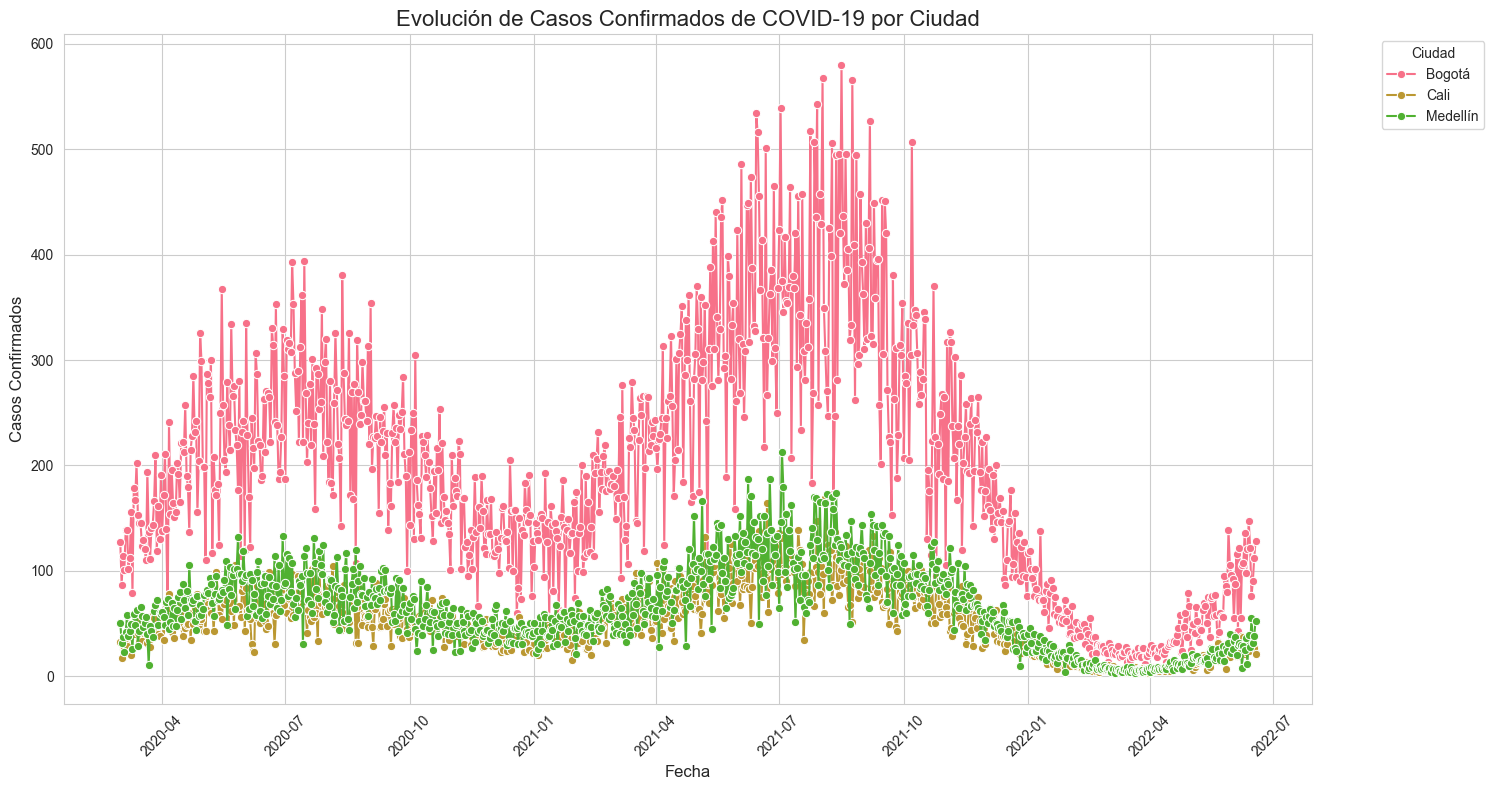


✅ Gráfico generado exitosamente.


In [33]:
# Por la función 'procesar_covid_automatico'
print(f'{"-"*10}📈 CREANDO GRÁFICO DE EVOLUCIÓN DE CASOS POR CIUDAD {"-"*10}')
print('-' * 70)

# Configuración básica del estilo del gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))

# Crear el gráfico de líneas con Seaborn
# 'x' es el eje de tiempo, 'y' son los casos confirmados
# 'hue' crea una línea diferente para cada 'Ciudad'
sns.lineplot(
    data=datos_automaticos,
    x='Fecha',
    y='Casos_Confirmados',
    hue='Ciudad',
    marker='o'  # Puntos en cada fecha para mayor claridad
)

# Personalizar el gráfico
plt.title('Evolución de Casos Confirmados de COVID-19 por Ciudad', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Casos Confirmados', fontsize=12)
plt.xticks(rotation=45) # Rotar las etiquetas del eje X para que no se solapen
plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left') # Mover la leyenda fuera del gráfico
plt.tight_layout() # Ajustar el diseño para evitar recortes
plt.show()

print('\n✅ Gráfico generado exitosamente.')

## 🎯 Resumen y Conclusiones del Análisis COVID-19

### ✅ Objetivos Cumplidos

En este notebook hemos aplicado exitosamente todas las técnicas de la **Semana 6: Reestructuración, Combinación y Automatización de Datos**:

1. **🔗 Combinación Vertical con `pd.concat()`**
   - Integramos los archivos de casos de 3 ciudades (Bogotá, Cali, Medellín) en un único DataFrame (2520 registros totales).
   - Unificamos los nombres de las ciudades para asegurar la consistencia en el conjunto de datos.

2. **🤝 Combinación Horizontal con `pd.merge()`**
   - Enriquecimos los datos de casos con información de vacunación y demografía (uso de LEFT JOIN).
   - Manejamos la integración de múltiples fuentes de datos sobre las columnas clave (Fecha y Ciudad).

3. **🔄 Reordenamiento y Reestructuración**
   - Ordenamos los datos cronológicamente para el análisis de tendencias de la pandemia.
   - Creamos variables derivadas y vistas agregadas (por ciudad y por mes) para análisis de métricas clave.
   - Creación de vistas agregadas y tablas pivote

4. **🤖 Automatización de Procesos**
   - Diseñamos funciones reutilizables (procesar_covid_automatico) para ejecutar todo el pipeline.
   - Implementamos la generación automática de métricas de la pandemia y la exportación en múltiples formatos.
   - Exportación automatizada en múltiples formatos

5. **✅ Validación y Exportación**
   - Realizamos validaciones de calidad para asegurar la integridad de los datos finales.
   - Exportamos el resultado en CSV, Excel, Parquet y JSON.
   - Generamos un resumen ejecutivo (.txt) con las principales métricas y el estado de la pandemia.

### ✅ Concluiones del desarrollo de la actividad

1. El mayor logro de este proyecto fue reunir información dispersa de diferentes archivos y ciudades. Tomamos datos de casos, vacunación y población, que estaban separados, y los unimos en una única base de datos. Lo que nos permite ver la situación completa de la pandemia para Bogotá, Cali y Medellín.

2. En lugar de hacer todo el trabajo a mano cada vez, creamos un Pipeline. Ahora, todo el proceso de limpieza, unión y análisis de datos se ejecuta solo. Esto es genial porque, si el Ministerio de Salud nos da datos nuevos, podemos generar un informe actualizado con solo un clic, ahorrando tiempo y asegurando que los resultados sean siempre los mismos y fiables.

3. No nos quedamos solo con la cantidad de casos. Creamos medidas clave, como la tasa de personas que lamentablemente fallecieron o se recuperaron. Estas cifras nos ayudan a entender el impacto real de la enfermedad y la eficacia de los tratamientos. También preparamos el terreno para futuros análisis, por ejemplo, para ver si las vacunas ayudaron a reducir la gravedad de los casos.

4. Antes de empezar a analizar, es fundamental revisar que los datos estén completos y sean correctos. Esta experiencia nos recuerda que un buen análisis de datos siempre debe empezar por una buena revisión de los datos iniciales para evitar conclusiones incompletas.